In [1]:
import numpy as np
from scipy import stats
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from matplotlib import pyplot
from pandas import DataFrame
from sklearn.linear_model import LogisticRegression 

%matplotlib inline
"""
First, train a model to estimate p(x,y)
Then use the p(x,y) matrix to get qi=max(0.5, p(i,1),..., p(i,K))
Then use these q to calculate a(x,y)
Then use a(x,y) to sample zi
At last use the subampled set {(xi,yi)|zi=1} to fit logistic model

"""

'\nFirst, train a model to estimate p(x,y)\nThen use the p(x,y) matrix to get qi=max(0.5, p(i,1),..., p(i,K))\nThen use these q to calculate a(x,y)\nThen use a(x,y) to sample zi\nAt last use the subampled set {(xi,yi)|zi=1} to fit logistic model\n\n'

In [2]:
def Bernoulli(p):
    np.random.seed(int(time.time()))
    if np.random.random()<p :
        return 1
    else :
        return 0
    
def get_Q(P_xy):
    """
    P_xy is the K*n matrix indicating probability p(xi,yi=k)
    return Q is n*1 matrix indicating qi=max(0.5, p(i,1),..., p(i,K))
    
    """
    K, n = np.shape(P_xy)
    Q = np.max(P_xy, axis=0)
    Q[Q<0.5]=0.5
    return Q


def get_A(P_xy, gamma):
    """
    gamma>1 is a parameter
    return A K*n is the sampling probability 改成n*K?
    
    """
    K, n = np.shape(P_xy)
    Q=get_Q(P_xy)
    a = 2*Q/gamma
    a[a>1]=1
    A=np.matrix([a, ]* K)
    A=np.asarray(A)
    idx=np.argmax(P_xy, axis=0)#每一列最大值
    for i in range(0, n):
            if(P_xy[idx[i], i]>=0.5):
                A[idx[i], i]=(1-Q[i])/(gamma-np.max([Q[i], 0.5*gamma]))
    return A.T


def get_Z(P_xy, Y, gamma):
    """
    sample zi~Bernoulli(a(xi, yi): zi=1)
    class label Y is needed, each value yi is in [0, K-1]
    return Z n*1 {0,1} matrix indicating whether to use that sample
    
    """
    n, = Y.shape
    A = get_A(P_xy, gamma)
    Z = np.zeros(n)
    i=0
    for i in range(0,n):
        Z[i]=Bernoulli(A[i, int(Y[i])])
        
    return Z


def get_sample(X, Y, P_xy, gamma):
    """
    subsample X and Y to get training sample and also the corresponding A
    X is n*p
    y is n
    
    """
    Z = get_Z(P_xy, Y, gamma)
    X_sample = X[Z==1, :]
    Y_sample = np.array(Y)[Z==1]
    A = get_A(P_xy, gamma)
    A_sample = A[Z==1, :]
    return X_sample, Y_sample, A_sample

In [3]:
def initialize_W_b(X, K):
    """
    X is n*d
    K is number of classes
    return W is K-1*d
    return b is K-1
    """
    n, d = np.shape(X)
    W = np.random.rand(K-1, d)
    b = np.random.rand(K-1)
    return W, b
    
    
def likelihood(X, y, W, b, A):
    """
    A n*K
    return the log likelihood
    """
    n, d= np.shape(X)
    n, K=np.shape(A)
    
    #应该用 X*W.T 得到n*(K-1)的f(X)矩阵
    f_X = np.dot(X, W.T) + b
    #first K-1 columns of A
    A_first = A[ : ,0:K-1 ]
    e_f = np.exp(f_X)
    denumerator = e_f * A_first#n*K-1
    denumerator = 1+ np.sum(denumerator, axis = 1)*(1/A[ : , K-1])#/a(xi,K),这一步后得到的形状是(n, )
    Indicator_matrix = np.zeros([n, K-1])#n*K-1
    for i in range(0, n):
        if y[i]!=K-1:
            Indicator_matrix[i, int(y[i])] = 1
    part1=Indicator_matrix*f_X#n*K-1
    part2=np.log(denumerator)#n
    ll=(np.sum(part1)-np.sum(part2))/n
    return ll
    
    
def getGradient(X, y, A, W, b):
    """
    return the gradient GradW K-1*d, Gradb K-1
    """
    n, d= np.shape(X)
    n, K=np.shape(A)
    GradW = np.zeros([K-1, d])
    Gradb = np.zeros(K-1)
    
    #first K-1 columns of A
    A_first = A[ : ,0:K-1 ]
    f_X = np.dot(X, W.T) + b
    e_f = np.exp(f_X)
    denumerator = e_f * A_first#n*K-1
    denumerator = 1+ np.sum(denumerator, axis = 1)*(1/A[ : , K-1])#/a(xi,K),这一步后得到的形状是(n, )
    for j in range(0, K-1):
        Indicator = np.zeros(n)
        Indicator[y==j] = 1
        gradw = np.dot(Indicator, X)
        temp = e_f[ : , j]*A[ : , j]/(A[ : , K-1]*denumerator)
        gradw = gradw - np.dot(temp, X)
        gradw = gradw/n
        GradW[ j , : ] = gradw
        gradb = sum(Indicator)-np.sum(temp)
        Gradb[j] = gradb/n
    
    return GradW, Gradb
    
def multi_class_logistic_regression(X, y, K, A, lr, decay, num_iter):
    """
    Main function, return W
    
    """
    W, b = initialize_W_b(X, K)
    hist = np.zeros(num_iter)#record the history of log likelihood
    for i in range(0, num_iter):
        #print("iteration %", i)
        ll = likelihood(X, y, W, b, A)
        hist[i]=ll
        gradW, gradb = getGradient(X, y, A, W, b)
        b = b + lr*gradb*decay**(i)
        W = W + lr*gradW*decay**(i)
    
    return W, b, hist



def predict(X, W, b):
    """
    Predict function, return a vector y n*1
    """
    n, d= np.shape(X)
    K, d = np.shape(W)
    y_pred = np.zeros(n)
    f_X = np.dot(X, W.T) + b
    e_f = np.exp(f_X)
    Prob = np.hstack((e_f, np.ones((n,1))))
    y_pred = np.argmax(Prob, axis = 1)
    return y_pred

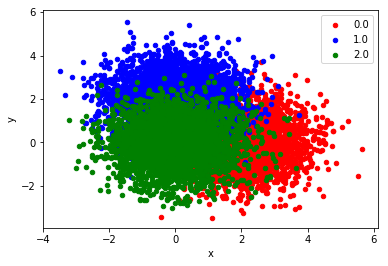

C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy is:  0.9763333333333334
(1979, 10)
(1979, 3)


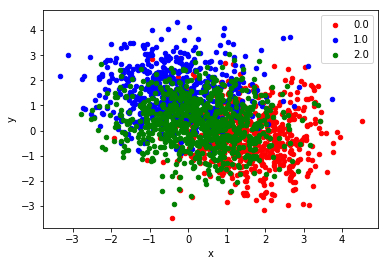

In the sampled data, there are  622 points from class 0
In the sampled data, there are  545 points from class 1
In the sampled data, there are  812 points from class 2


'\nsample_fraction = np.zeros(11)\nfor i in range(11):\n    classifier = LogisticRegression()\n    classifier.fit(X_pilot, y_pilot)\n    P_xy = classifier.predict_proba(X)\n    P_xy = P_xy.T\n    X_ss, y_ss, A_ss = get_sample(X, y, P_xy, gamma)\n    sample_fraction[i] = y_ss.shape[0]/n\n    \nplt.plot(sample_fraction)'

In [41]:
"""
In this section we will do simulations in the case that samples are marginally balance
In our setting let K=3, n=9000, d=10
For marginally balanced case, p(y=0)=p(y=1)=p(y=2)=1/3
We generate a 3-class Gaussian model according to (X|Y = k) ∼ N (µk, Σk)

"""
n=9000
K=3
d=10
gamma=2
p1=p2=p3=1/3


n1=int(n*p1)
n2=int(n*p2)
n3=int(n*p3)
cov=np.identity(d)
mean1=np.array((2,2,2,2,2,0,0,0,0,0))
mean2=np.array((0,0,0,0,0,2,2,2,2,2))
mean3=np.array((0,0,0,0,0,0,0,0,0,0))
X=np.zeros((n, d))
y=np.zeros(n)
for i in range(0,n1):
    X[i, : ]=np.random.multivariate_normal(mean1, cov)
    y[i]=0
for i in range(n1, n1+n2):
    X[i, : ]=np.random.multivariate_normal(mean2, cov)
    y[i]=1
for i in range(n1+n2, n):
    X[i, : ]=np.random.multivariate_normal(mean3, cov)
    y[i]=2

X_test=np.zeros((n, d))
y_test=np.zeros(n)
for i in range(0,n1):
    X_test[i, : ]=np.random.multivariate_normal(mean1, cov)
    y_test[i]=0
for i in range(n1, n1+n2):
    X_test[i, : ]=np.random.multivariate_normal(mean2, cov)
    y_test[i]=1
for i in range(n1+n2, n):
    X_test[i, : ]=np.random.multivariate_normal(mean3, cov)
    y_test[i]=2  
    
    
    
df = DataFrame(dict(x=X[:,0], y=X[:,5], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()


X_pilot = X[::6, ]
y_pilot = y[::6]
#X_pilot = X
#y_pilot = y
classifier = LogisticRegression()
classifier.fit(X_pilot, y_pilot)
#sum((classifier.predict(X_pilot)!=y_pilot))
P_xy = classifier.predict_proba(X)
P_xy = P_xy.T
print("accuracy is: ",(1-sum(classifier.predict(X)!=y)/X.shape[0]))
A = get_A(P_xy, gamma)
X_train, y_train, A_train= get_sample(X, y, P_xy, gamma)
print(X_train.shape)
print(A_train.shape)
df = DataFrame(dict(x=X_train[:,0], y=X_train[:,5], label=y_train))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()


print("In the sampled data, there are ",sum(y_train==0) ,"points from class 0")
print("In the sampled data, there are ",sum(y_train==1) ,"points from class 1")
print("In the sampled data, there are ",sum(y_train==2) ,"points from class 2")

"""
sample_fraction = np.zeros(11)
for i in range(11):
    classifier = LogisticRegression()
    classifier.fit(X_pilot, y_pilot)
    P_xy = classifier.predict_proba(X)
    P_xy = P_xy.T
    X_ss, y_ss, A_ss = get_sample(X, y, P_xy, gamma)
    sample_fraction[i] = y_ss.shape[0]/n
    
plt.plot(sample_fraction)"""

In [42]:
print("There are ", y_train.shape[0], " samples in the LUS sample")
W, b, hist = multi_class_logistic_regression(X_train, y_train, K, A_train, lr=0.0015, decay=1, num_iter=25000)
y_pred = predict(X_test, W, b)
print("Test accuracy on test set of LUS trained on LUS sample is" ,(1-sum((y_pred!=y_test)/X_test.shape[0])))
#The test accuracy is not good because 25000 iterations is not enough for my algorithm to converge...
#Doing experiments is too time consuming
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("Test accuracy on test set of given classifier trained on LUS sample is ", (1-sum((y_pred!=y_test)/X_test.shape[0])))
classifier.fit(X_pilot, y_pilot)
y_pred = classifier.predict(X_train)
print("The accuracy on LUS sample of given classifier trained on the pilot sample is ", (1-sum((y_pred!=y_train)/X_train.shape[0])))
classifier.fit(X_pilot, y_pilot)
y_pred = classifier.predict(X_test)
print("The accuracy on test data of given classifier trained on the pilot sample is ", (1-sum((y_pred!=y_test)/X_test.shape[0])))

classifier.fit(X, y)
y_pred = classifier.predict(X_train)
print("The accuracy on LUS sample of given classifier trained on all data is", (1-sum((y_pred!=y_train)/X_train.shape[0])))

There are  1979  samples in the LUS sample
Test accuracy on test set of LUS trained on LUS sample is 0.9724444444444446
Test accuracy on test set of given classifier trained on LUS sample is  0.9814444444444445
The accuracy on LUS sample of given classifier trained on the pilot sample is  0.8923698837796865
The accuracy on test data of given classifier trained on the pilot sample is  0.9767777777777779
The accuracy on LUS sample of given classifier trained on all data is 0.9044972208185951


C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: 

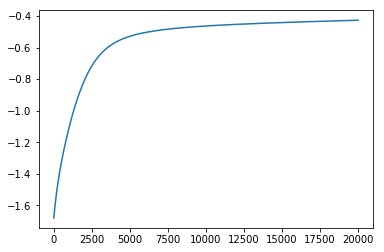

In [304]:
plt.plot(hist)

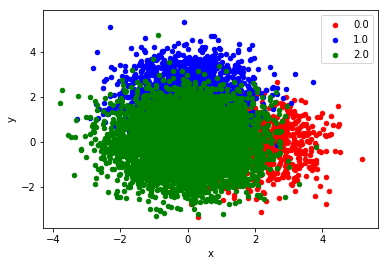

C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


accuracy is:  0.9773333333333334
(1323, 10)
(1323, 3)


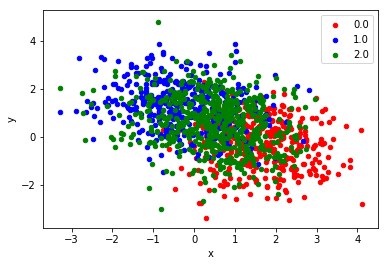

In the sampled data, there are  384 points from class 0
In the sampled data, there are  379 points from class 1
In the sampled data, there are  560 points from class 2


In [60]:
"""
In this section we generate marginally imbalanced data
In our setting let K=3, n=9000, d=10
For marginally balanced case, p(y=0)=0.1, p(y=1)=0.2, p(y=2)=0.7
We generate a 3-class Gaussian model according to (X|Y = k) ∼ N (µk, Σk)
"""
n=9000
K=3
d=10
gamma=1.3
p1=0.1
p2=0.2
p3=0.7

n1=int(n*p1)
n2=int(n*p2)
n3=int(n*p3)
cov=np.identity(d)
mean1=np.array((2,2,2,2,2,0,0,0,0,0))
mean2=np.array((0,0,0,0,0,2,2,2,2,2))
mean3=np.array((0,0,0,0,0,0,0,0,0,0))
X=np.zeros((n, d))
y=np.zeros(n)
for i in range(0,n1):
    X[i, : ]=np.random.multivariate_normal(mean1, cov)
    y[i]=0
for i in range(n1, n1+n2):
    X[i, : ]=np.random.multivariate_normal(mean2, cov)
    y[i]=1
for i in range(n1+n2, n):
    X[i, : ]=np.random.multivariate_normal(mean3, cov)
    y[i]=2
    
    
    
X_test=np.zeros((n, d))
y_test=np.zeros(n)
for i in range(0,n1):
    X_test[i, : ]=np.random.multivariate_normal(mean1, cov)
    y_test[i]=0
for i in range(n1, n1+n2):
    X_test[i, : ]=np.random.multivariate_normal(mean2, cov)
    y_test[i]=1
for i in range(n1+n2, n):
    X_test[i, : ]=np.random.multivariate_normal(mean3, cov)
    y_test[i]=2  
    
    
df = DataFrame(dict(x=X[:,0], y=X[:,5], label=y))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()


X_pilot = X[::6, ]
y_pilot = y[::6]
classifier = LogisticRegression()
classifier.fit(X_pilot, y_pilot)
#sum((classifier.predict(X_pilot)!=y_pilot))
P_xy = classifier.predict_proba(X)
P_xy = P_xy.T
print("accuracy is: ",(1-sum(classifier.predict(X)!=y)/X.shape[0]))
X_train, y_train, A_train= get_sample(X, y, P_xy, gamma)
print(X_train.shape)
print(A_train.shape)
df = DataFrame(dict(x=X_train[:,0], y=X_train[:,5], label=y_train))
colors = {0:'red', 1:'blue', 2:'green'}
fig, ax = pyplot.subplots()
grouped = df.groupby('label')
for key, group in grouped:
    group.plot(ax=ax, kind='scatter', x='x', y='y', label=key, color=colors[key])
pyplot.show()

print("In the sampled data, there are ",sum(y_train==0) ,"points from class 0")
print("In the sampled data, there are ",sum(y_train==1) ,"points from class 1")
print("In the sampled data, there are ",sum(y_train==2) ,"points from class 2")

In [61]:
print("There are ", y_train.shape[0], " samples in the LUS sample")
W, b, hist = multi_class_logistic_regression(X_train, y_train, K, A_train, lr=0.0015, decay=1, num_iter=25000)
y_pred = predict(X_test, W, b)
print("Test accuracy on test set of LUS trained on LUS sample is" ,(1-sum((y_pred!=y_test)/X_test.shape[0])))
#The test accuracy is not good because 25000 iterations is not enough for my algorithm to converge...
#Doing experiments is too time consuming
classifier.fit(X_train, y_train)
y_pred = classifier.predict(X_test)
print("Test accuracy on test set of given classifier trained on LUS sample is ", (1-sum((y_pred!=y_test)/X_test.shape[0])))
classifier.fit(X_pilot, y_pilot)
y_pred = classifier.predict(X_train)
print("The accuracy on LUS sample of given classifier trained on the pilot sample is ", (1-sum((y_pred!=y_train)/X_train.shape[0])))
classifier.fit(X_pilot, y_pilot)
y_pred = classifier.predict(X_test)
print("The accuracy on test data of given classifier trained on the pilot sample is ", (1-sum((y_pred!=y_test)/X_test.shape[0])))

classifier.fit(X, y)
y_pred = classifier.predict(X_train)
print("The accuracy on LUS sample of given classifier trained on all data is", (1-sum((y_pred!=y_train)/X_train.shape[0])))

There are  1323  samples in the LUS sample
Test accuracy on test set of LUS trained on LUS sample is 0.9321111111111111
Test accuracy on test set of given classifier trained on LUS sample is  0.9822222222222222
The accuracy on LUS sample of given classifier trained on the pilot sample is  0.8458049886621312
The accuracy on test data of given classifier trained on the pilot sample is  0.9774444444444446
The accuracy on LUS sample of given classifier trained on all data is 0.859410430839002


C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)
C:\Users\Misika Mei\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: 

The accuracy of LUS trained on LUS sample is 0.9515555555555558


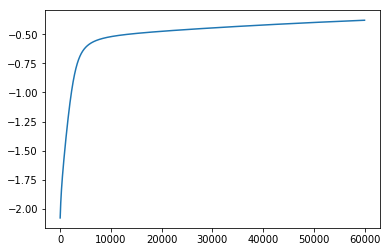

In [327]:
W, b, hist = multi_class_logistic_regression(X_train, y_train, K, A_train, lr=0.0015, decay=1, num_iter=60000)
y_pred = predict(X, W, b)
print("The accuracy of LUS trained on LUS sample is" ,(1-sum((y_pred!=y)/X.shape[0])))
plt.plot(hist)

array([[0.28921067, 0.96078933, 0.96078933],
       [0.58403232, 0.66596768, 0.66596768],
       [0.66097096, 0.66097096, 0.58902904],
       ...,
       [0.91524421, 0.91524421, 0.33475579],
       [0.94934436, 0.94934436, 0.30065564],
       [0.69472881, 0.69472881, 0.55527119]])